# FinOL
## Tutorial 2: Loading the Dataset
In Tutorial 2, we will use the dataset ``NYSE(O)`` as an example to implement a complete data call. In ``FinOL``, the call to the dataset is encapsulated in a function, which concatenates all the functions covered in Tutorial 1. You only need to configure the parameters related to the data layer in ``config.py`` to obtain the dataset.

Similarly, to get started, we first import ``data_loader`` from the ``FinOL`` package and configure the environment for Tutorial 2:

In [1]:
import re
from finol.data_layer.data_loader import *
from finol.config import *

with open(ROOT_PATH + '/config.py', 'r') as file:
    content = file.read()

content = re.sub(r'(TUTORIAL_MODE\s*=\s*).*', r'\g<1>True', content)
content = re.sub(r'(TUTORIAL_NAME\s*=\s*").*?(")', r'\g<1>' + "TUTORIAL_2" + r'\g<2>', content)

with open(ROOT_PATH + '/config.py', 'w') as file:
    file.write(content)


**Configuring the Data Layer**

To load the dataset, the following parameters need to be configured in ``config.py``:

```python
DATASET_NAME = "NYSE(O)"
FEATURE_ENGINEERING_CONFIG = {
    "INCLUDE_OHLCV_FEATURES": True,
    "INCLUDE_OVERLAP_FEATURES": True,
    "INCLUDE_MOMENTUM_FEATURES": True,
    "INCLUDE_VOLUME_FEATURES": True,
    "INCLUDE_CYCLE_FEATURES": True,
    "INCLUDE_PRICE_FEATURES": True,
    "INCLUDE_VOLATILITY_FEATURES": True,
    "INCLUDE_PATTERN_FEATURES": True
}
DATA_AUGMENTATION_CONFIG = {
    "WINDOW_DATA": {
        "INCLUDE_WINDOW_DATA": False,
        "WINDOW_SIZE": 10
    }
}
SCALER = "MinMaxScaler"  # None, StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
BATCH_SIZE = 128
```

**However, not all parameters can be adjusted, such as the division of training sets, verification sets, and test sets, we recommend that no adjustments be made.**

Once the parameters have been configured in ``config.py``, one can easily load the dataset using the following code:

```python
load_dataset_output = load_dataset()
````

The ``load_dataset`` function will divide the complete dataset into separate training, validation and test sets, and encapsulates them into PyTorch DataLoader objects for easy batch processing.

In [2]:
# Load the dataset using the load_dataset function
load_dataset_output = load_dataset()
load_dataset_output

Data Loading: 100%|██████████| 26/26 [00:14<00:00,  1.78it/s]


Successfully loaded 26 Excel file(s):

Data Processing: 100%|██████████| 26/26 [00:37<00:00,  1.46s/it]


{'train_loader': <torch.utils.data.dataloader.DataLoader at 0x17070dc8880>,
 'val_loader': <torch.utils.data.dataloader.DataLoader at 0x17070dc8790>,
 'test_loader': <torch.utils.data.dataloader.DataLoader at 0x17070dc8b20>,
 'NUM_TRAIN_PERIODS': 3293,
 'NUM_VAL_PERIODS': 1130,
 'NUM_TEST_PERIODS': 1131,
 'NUM_ASSETS': 26,
 'NUM_FEATURES_AUGMENTED': 1430,
 'NUM_FEATURES_ORIGINAL': 143,
 'DETAILED_NUM_FEATURES': {'OHLCV_FEATURES': 5,
  'OVERLAP_FEATURES': 20,
  'MOMENTUM_FEATURES': 40,
  'VOLUME_FEATURES': 3,
  'CYCLE_FEATURES': 7,
  'PRICE_FEATURES': 4,
  'VOLATILITY_FEATURES': 3,
  'PATTERN_FEATURES': 61},
 'WINDOW_SIZE': 10,
 'OVERALL_FEATURE_LIST': ['OHLCV_FEATURES',
  'OVERLAP_FEATURES',
  'MOMENTUM_FEATURES',
  'VOLUME_FEATURES',
  'CYCLE_FEATURES',
  'PRICE_FEATURES',
  'VOLATILITY_FEATURES',
  'PATTERN_FEATURES'],
 'DETAILED_FEATURE_LIST': ['OPEN',
  'HIGH',
  'LOW',
  'CLOSE',
  'VOLUME',
  'BBANDS_UPPER',
  'BBANDS_MIDDLE',
  'BBANDS_LOWER',
  'DEMA',
  'EMA',
  'HT_TRENDLINE'

DataLoaders are useful for batch-based training as they allow efficiently iterating over datasets. They will feed mini-batches of samples into our model during training. The following code demonstrates the process of iterating over the training loader to access the training data batches.

To validate the loaders, we iterate over the training set using ``enumerate`` and break out of the loop after one batch. This prints the batch number, shape of the input features and shape of labels for the first batch. This acts as a sanity check in the tutorial.

In [3]:
train_loader = load_dataset_output["train_loader"]
concatenated_data = []
concatenated_label = []

# Iterate over the training loader
for i, data in enumerate(train_loader, 1):
    # Extract the input data and labels from the batch
    x_data, label = data

    print(f'Number of batch: {i} \n'
          f'Shape of x_data: {x_data.shape} \n'
          f'Shape of label: {label.shape}')
    break
    # concatenated_data.append(x_data)
    # concatenated_label.append(label)

    # Print the batch information

# Concatenate the tensors in the concatenated_data and concatenated_label lists
# concatenated_data = torch.cat(concatenated_data, dim=0)
# concatenated_label = torch.cat(concatenated_label, dim=0)

# Print the shape of the concatenated tensors
# print(f'Shape of concatenated_data: {concatenated_data.shape}')
# print(f'Shape of concatenated_label: {concatenated_label.shape}')

Number of batch: 1 
Shape of x_data: torch.Size([128, 26, 1430]) 
Shape of label: torch.Size([128, 26])

Based on the specific dataset and preprocessing pipeline used. Here the expected shape of the input ``x_data`` should be ``torch.size([128, 26, 1430])``. We can see it has a batch size of 128 samples (periods), with 26 assets, and the feature representation for each asset has a very high dimension of 1430 after preprocessing by ``data_layer``.

This high dimensional feature embedding is expected since the dataset has likely undergone transformations like feature engineering, data augmentation, and other transformations to capture deep representation of assets.

The shape of ``label`` should be ``torch.size([128, 26])``. Similar to the ``x_data``, the dimensions are specified as ``[BATCH_SIZE, NUM_ASSETS]``, and each sample of input data (``torch.size([26, 1430])``) is paired with its corresponding label (price relative vector, ``torch.size([26])``).

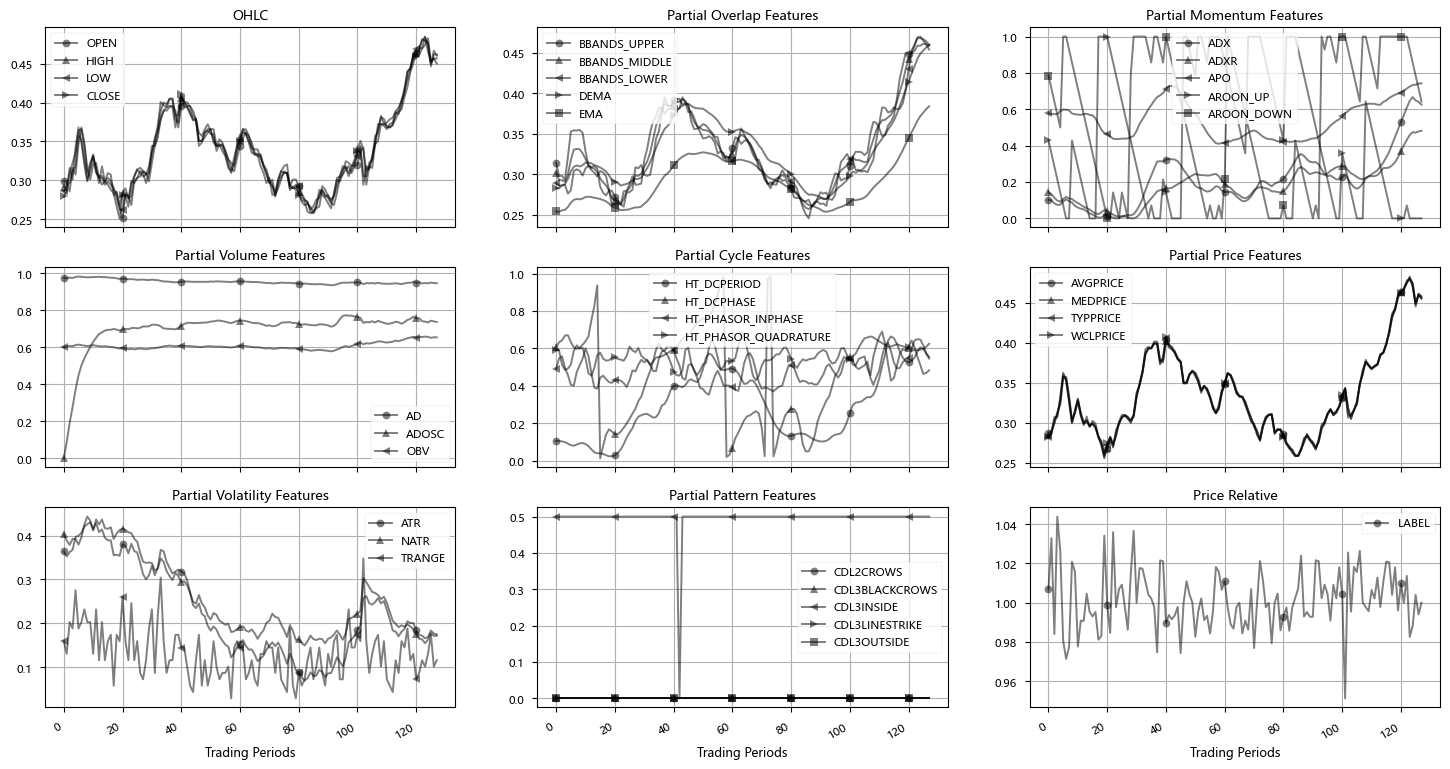

In [4]:
import matplotlib.pyplot as plt


def plot_features(axs, features, title, begin_index):
    for i, m in enumerate(features):
        axs.plot(x_data[:, ASSET_INDEX, begin_index+i], marker=MARKERS[i], color='black', markevery=MARKEVERY*2, alpha=ALPHA)
    axs.set_title(title)
    axs.legend(features, loc='best')
    axs.grid(True)
    axs.set_xlabel('Trading Periods')

ASSET_INDEX = 0
fig, axs = plt.subplots(3, 3, figsize=(18, 10))

# plot the subplot of OHLC
OHLC = ['OPEN', 'HIGH', 'LOW', 'CLOSE']
plot_features(axs[0, 0], OHLC, 'OHLC', 0)

# plot the subplot of partial_overlap_features
partial_overlap_features = ['BBANDS_UPPER', 'BBANDS_MIDDLE', 'BBANDS_LOWER', 'DEMA', 'EMA']
plot_features(axs[0, 1], partial_overlap_features, 'Partial Overlap Features', 5)

# plot the subplot of partial_momentum_features
partial_momentum_features = ['ADX', 'ADXR', 'APO', 'AROON_UP', 'AROON_DOWN']
plot_features(axs[0, 2], partial_momentum_features, 'Partial Momentum Features', 25)

# plot the subplot of partial_volume_features
partial_volume_features = ['AD', 'ADOSC', 'OBV']
plot_features(axs[1, 0], partial_volume_features, 'Partial Volume Features', 65)

# plot the subplot of partial_cycle_features
partial_cycle_features = ['HT_DCPERIOD', 'HT_DCPHASE', 'HT_PHASOR_INPHASE', 'HT_PHASOR_QUADRATURE']
plot_features(axs[1, 1], partial_cycle_features, 'Partial Cycle Features', 68)

# plot the subplot of partial_price_features
partial_price_features = ['AVGPRICE', 'MEDPRICE', 'TYPPRICE', 'WCLPRICE']
plot_features(axs[1, 2], partial_price_features, 'Partial Price Features', 75)

# plot the subplot of partial_volatility_features
partial_volatility_features = ['ATR', 'NATR', 'TRANGE']
plot_features(axs[2, 0], partial_volatility_features, 'Partial Volatility Features', 79)

# plot the subplot of partial_pattern_features
partial_pattern_features = ['CDL2CROWS', 'CDL3BLACKCROWS', 'CDL3INSIDE', 'CDL3LINESTRIKE', 'CDL3OUTSIDE']
plot_features(axs[2, 1], partial_pattern_features, 'Partial Pattern Features', 82)

# plot the subplot of price_relative
axs[2, 2].plot(label[:, ASSET_INDEX].numpy(), marker=MARKERS[0], color='black', markevery=MARKEVERY*2, alpha=ALPHA)
axs[2, 2].set_title('Price Relative')
axs[2, 2].legend(['LABEL'], loc='best')
axs[2, 2].set_xlabel('Trading Periods')
axs[2, 2].grid(True)

fig.autofmt_xdate()
plt.show()

In future tutorials, we will use these DataLoaders to train models on mini-batches of data. The well-encapsulated data provided by the above steps is an important initial step in any machine learning workflow.